In [1]:
# Import necessary libraries
import numpy as np 
import pandas as pd 
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import os
from PIL import Image, ImageFile
import warnings

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", Image.DecompressionBombWarning)


In [2]:
# Define dataset path
data_dir = '/kaggle/input/ai-generated-images-vs-real-images/train'

# Image processing functions
Image.MAX_IMAGE_PIXELS = None

def convert_to_rgb(image):
    if image.mode == 'P':
        image = image.convert("RGBA")
    if image.mode == "RGBA":
        background = Image.new("RGB", image.size, (255, 255, 255))
        image = Image.alpha_composite(background, image).convert("RGB")
    elif image.mode != "RGB":
        image = image.convert("RGB")
    return image

def resize_large_image(image, max_size):
    if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
        image.thumbnail(max_size, Image.Resampling.LANCZOS)
    return image

# Define transformations
train_transform = transforms.Compose([
    transforms.Lambda(lambda img: resize_large_image(img, max_size=(5000, 5000))),
    transforms.Lambda(convert_to_rgb),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ImageFile.LOAD_TRUNCATED_IMAGES = True
MIN_IMAGE_FILE_SIZE = 3284

def is_valid_image(file_path):
    try:
        if os.path.getsize(file_path) < MIN_IMAGE_FILE_SIZE:
            return False
        with Image.open(file_path) as img:
            img.verify()
        return True
    except (OSError, Image.DecompressionBombError):
        return False

class ValidImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.samples = [(path, label) for path, label in self.samples if is_valid_image(path)]
        self.targets = [label for _, label in self.samples]

# Load dataset
dataset = ValidImageFolder(root=data_dir, transform=train_transform)

In [3]:
from torch.utils.data import Subset

fake_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == dataset.class_to_idx['fake']]
real_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == dataset.class_to_idx['real']]

fake_subset_size = int(1.0/2.0 * len(fake_indices))
real_subset_size = int(1.0/2.0 * len(real_indices))

fake_subset_indices = fake_indices[fake_subset_size:fake_subset_size*2]
real_subset_indices = real_indices[real_subset_size:real_subset_size*2]

balanced_subset_indices = np.concatenate((fake_subset_indices, real_subset_indices))
balanced_subset = Subset(dataset, balanced_subset_indices)

print(f"Original Dataset Size: {len(dataset)}")
print(f"Balanced Subset Size: {len(balanced_subset)} (Fake: {fake_subset_size}, Real: {real_subset_size})")

Original Dataset Size: 47998
Balanced Subset Size: 23999 (Fake: 12000, Real: 11999)


In [4]:
train_size = int(0.8 * len(balanced_subset))
val_size = len(balanced_subset) - train_size
train_dataset, val_dataset = random_split(balanced_subset, [train_size, val_size])

val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [5]:
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")

Train Dataset Size: 19199
Validation Dataset Size: 4800


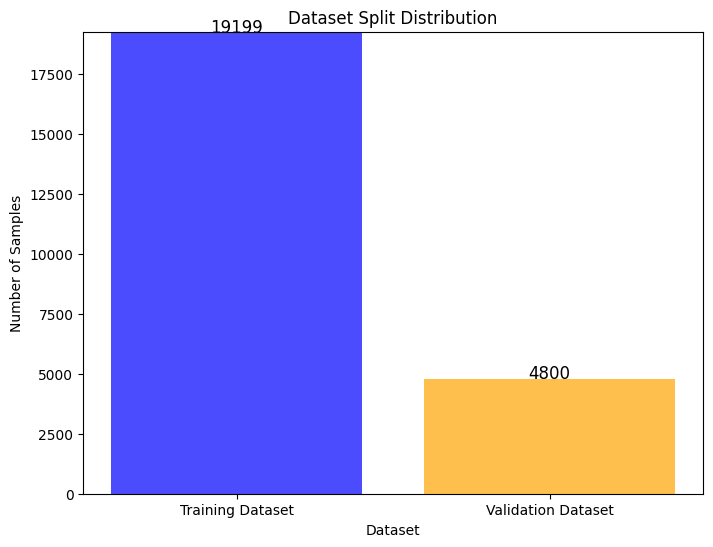

In [6]:
import matplotlib.pyplot as plt

train_size = len(train_dataset)
val_size = len(val_dataset)

labels = ['Training Dataset', 'Validation Dataset']
sizes = [train_size, val_size]

plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=['blue', 'orange'], alpha=0.7)

for i, size in enumerate(sizes):
    plt.text(i, size + 5, str(size), ha='center', fontsize=12)

plt.title('Dataset Split Distribution')
plt.ylabel('Number of Samples')
plt.xlabel('Dataset')
plt.ylim(0, max(sizes) + 50)
plt.show()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
import torchvision.models as models

# Load MobileNetV3-Small
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)

# Modify the classifier layer
num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, 2)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 128MB/s]


In [9]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [10]:
# Training and validation loop
patience = 6
trigger_times = 0
best_val_loss = float('inf')
epochs = 10
best_val_acc = 0.0

data = {
    "train_losses": [],
    "train_accuracies": [],
    "val_losses": [],
    "val_accuracies": [],
}

In [11]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    data["train_losses"].append(epoch_loss)
    data["train_accuracies"].append(epoch_acc.item())

    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

            # Store predictions and labels for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    data["val_losses"].append(val_loss)
    data["val_accuracies"].append(val_acc.item())

    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Precision, Recall, F1-Score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    if val_acc > best_val_acc:
        best_val_acc = val_acc

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model{epoch}_mobilenetv3_small.pth')
        trigger_times = 0  # Reset early stopping counter
    else:
        trigger_times += 1
        print(f"Early stopping trigger count: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping...")
            break

    # Step the scheduler
    scheduler.step()

print(f'Best Validation Accuracy: {best_val_acc:.4f}')
print(f'Best Validation Loss: {best_val_loss:.4f}')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.3646 Acc: 0.8391
Val Loss: 0.6705 Acc: 0.6977

Classification Report:
              precision    recall  f1-score   support

        fake       0.95      0.42      0.58      2420
        real       0.62      0.98      0.76      2380

    accuracy                           0.70      4800
   macro avg       0.79      0.70      0.67      4800
weighted avg       0.79      0.70      0.67      4800

Epoch 2/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2992 Acc: 0.8720
Val Loss: 0.7362 Acc: 0.7258

Classification Report:
              precision    recall  f1-score   support

        fake       0.95      0.48      0.64      2420
        real       0.65      0.98      0.78      2380

    accuracy                           0.73      4800
   macro avg       0.80      0.73      0.71      4800
weighted avg       0.80      0.73      0.71      4800

Early stopping trigger count: 1/6
Epoch 3/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2742 Acc: 0.8872
Val Loss: 0.3450 Acc: 0.8556

Classification Report:
              precision    recall  f1-score   support

        fake       0.85      0.86      0.86      2420
        real       0.86      0.85      0.85      2380

    accuracy                           0.86      4800
   macro avg       0.86      0.86      0.86      4800
weighted avg       0.86      0.86      0.86      4800

Epoch 4/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2296 Acc: 0.9063
Val Loss: 0.2495 Acc: 0.8985

Classification Report:
              precision    recall  f1-score   support

        fake       0.92      0.87      0.90      2420
        real       0.88      0.93      0.90      2380

    accuracy                           0.90      4800
   macro avg       0.90      0.90      0.90      4800
weighted avg       0.90      0.90      0.90      4800

Epoch 5/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2110 Acc: 0.9138
Val Loss: 0.2402 Acc: 0.8981

Classification Report:
              precision    recall  f1-score   support

        fake       0.93      0.86      0.90      2420
        real       0.87      0.93      0.90      2380

    accuracy                           0.90      4800
   macro avg       0.90      0.90      0.90      4800
weighted avg       0.90      0.90      0.90      4800

Epoch 6/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2034 Acc: 0.9171
Val Loss: 0.2379 Acc: 0.9052

Classification Report:
              precision    recall  f1-score   support

        fake       0.92      0.89      0.90      2420
        real       0.89      0.92      0.91      2380

    accuracy                           0.91      4800
   macro avg       0.91      0.91      0.91      4800
weighted avg       0.91      0.91      0.91      4800

Epoch 7/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1955 Acc: 0.9197
Val Loss: 0.2383 Acc: 0.9019

Classification Report:
              precision    recall  f1-score   support

        fake       0.91      0.89      0.90      2420
        real       0.89      0.91      0.90      2380

    accuracy                           0.90      4800
   macro avg       0.90      0.90      0.90      4800
weighted avg       0.90      0.90      0.90      4800

Early stopping trigger count: 1/6
Epoch 8/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1974 Acc: 0.9179
Val Loss: 0.2390 Acc: 0.9029

Classification Report:
              precision    recall  f1-score   support

        fake       0.91      0.89      0.90      2420
        real       0.89      0.91      0.90      2380

    accuracy                           0.90      4800
   macro avg       0.90      0.90      0.90      4800
weighted avg       0.90      0.90      0.90      4800

Early stopping trigger count: 2/6
Epoch 9/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1923 Acc: 0.9196
Val Loss: 0.2272 Acc: 0.9102

Classification Report:
              precision    recall  f1-score   support

        fake       0.92      0.90      0.91      2420
        real       0.90      0.92      0.91      2380

    accuracy                           0.91      4800
   macro avg       0.91      0.91      0.91      4800
weighted avg       0.91      0.91      0.91      4800

Epoch 10/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1977 Acc: 0.9209
Val Loss: 0.2322 Acc: 0.9046

Classification Report:
              precision    recall  f1-score   support

        fake       0.91      0.90      0.90      2420
        real       0.90      0.91      0.90      2380

    accuracy                           0.90      4800
   macro avg       0.90      0.90      0.90      4800
weighted avg       0.90      0.90      0.90      4800

Early stopping trigger count: 1/6
Best Validation Accuracy: 0.9102
Best Validation Loss: 0.2272


In [12]:
df = pd.DataFrame(data)

In [13]:
print(data)

{'train_losses': [0.36464110718610926, 0.29917210335687794, 0.27417509246228905, 0.2295907676806704, 0.21102180160534334, 0.20342293401715458, 0.1955229495458227, 0.19736353829025732, 0.19232050824431715, 0.19766918987329132], 'train_accuracies': [0.8391062034480963, 0.872024584613782, 0.8872337100890672, 0.9063492890254701, 0.913797593624668, 0.9171311005781551, 0.9196833168394187, 0.9179123912703786, 0.9195791447471222, 0.9208812959008281], 'val_losses': [0.6705203572909038, 0.7361666218439737, 0.34503596981366474, 0.24946574489275614, 0.240168474316597, 0.23790841341018676, 0.23829890588919322, 0.23903269251187642, 0.22720009366671245, 0.2321577783425649], 'val_accuracies': [0.6977083333333334, 0.7258333333333333, 0.8556250000000001, 0.8985416666666667, 0.8981250000000001, 0.9052083333333334, 0.9018750000000001, 0.9029166666666667, 0.9102083333333334, 0.9045833333333334]}


In [14]:
df

,train_losses,train_accuracies,val_losses,val_accuracies
0,0.364641,0.839106,0.670520,0.697708
1,0.299172,0.872025,0.736167,0.725833
2,0.274175,0.887234,0.345036,0.855625
3,0.229591,0.906349,0.249466,0.898542
4,0.211022,0.913798,0.240168,0.898125
5,0.203423,0.917131,0.237908,0.905208
6,0.195523,0.919683,0.238299,0.901875
7,0.197364,0.917912,0.239033,0.902917
8,0.192321,0.919579,0.227200,0.910208
9,0.197669,0.920881,0.232158,0.904583


In [15]:
df.to_csv("/kaggle/working/MobileNet_2-3ofData.csv", index=False)
print("CSV file saved successfully!")

CSV file saved successfully!


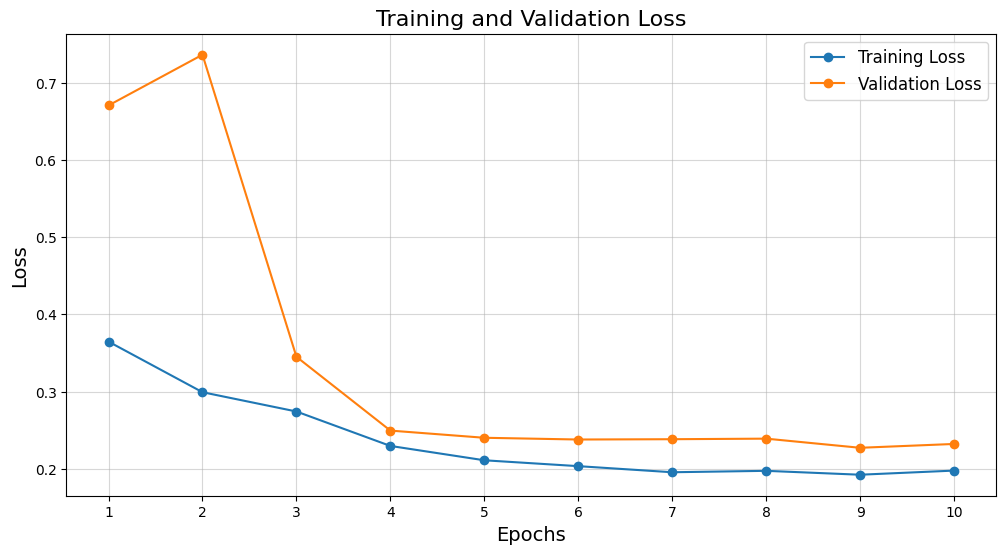

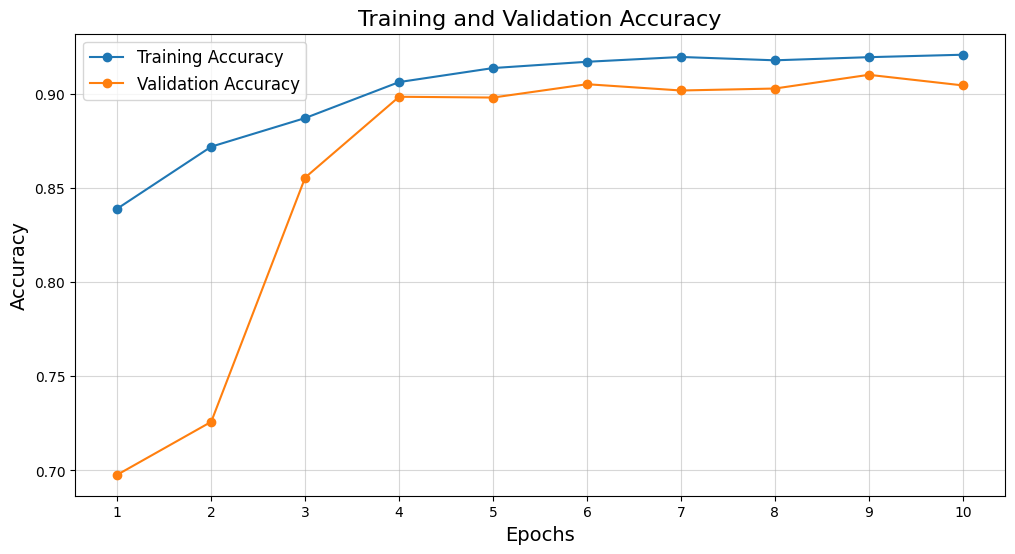

In [16]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data["train_losses"]) + 1), data["train_losses"], label='Training Loss', marker='o')
plt.plot(range(1, len(data["val_losses"]) + 1), data["val_losses"], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(range(1, len(data["train_losses"]) + 1))
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data["train_accuracies"]) + 1), data["train_accuracies"], label='Training Accuracy', marker='o')
plt.plot(range(1, len(data["val_accuracies"]) + 1), data["val_accuracies"], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(range(1, len(data["train_accuracies"]) + 1))
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()